In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
import photutils

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=18)

In [2]:
#Getting the index for all the different calibration and data files

bias = np.arange(2030,2035,1)
dark = np.arange(2025, 2030,1)

dflatB = np.arange(2003, 2013,1)

dflatV = np.arange(2015, 2025, 1)

ngcV = np.arange(2124, 2128, 1)
ngcV = np.append(ngcV, 2132)

ngcB = np.arange(2118, 2122, 1)

ldltV = np.arange(2129, 2132, 1)
ldltB = np.arange(2113, 2117, 1)

In [3]:
#defining functions to do all the calibration. Copied 90% from Pluto lab

def get_bias(bias_index):
    bias_master = np.zeros(shape=(len(bias_index), 1024, 1056))
    
    i=0
    for bi in bias_index:
        loop_hdul = fits.open('C:\\Users\\dougl\\Desktop\\Githubwork\\Calibration HR\d'+str(bi)+'.fits')
        loop_img = np.asarray(loop_hdul[0].data)

        bias_master[i,:] = loop_img

        i+=1
        
    bias_median = np.nanmedian(bias_master, axis=0)
    
    return bias_median

def get_dark(dark_index, time, bias_median):
    dark_master = np.zeros(shape=(len(dark_index), 1024, 1056))
    
    i =0
    for d in dark_index:
        loop_hdul = fits.open('C:\\Users\\dougl\\Desktop\\Githubwork\\Calibration HR\d'+str(d)+'.fits')
        loop_img = np.asarray(loop_hdul[0].data)

        dark_master[i, :] = (loop_img-bias_median)/time #subtracting bias from dark and dividing by exposure time.
        i+=1
    
    dark_median = np.nanmedian(dark_master, axis=0)
    
    return dark_median

def get_flats(flat_index, time, bias_median, dark_median):
    flats_master = np.zeros(shape=(len(flat_index), 1024, 1056))
    
    i=0
    for f in flat_index:
        loop_hdul = fits.open('C:\\Users\\dougl\\Desktop\\Githubwork\\Calibration HR\d'+str(f)+'.fits')
        loop_img = np.asarray(loop_hdul[0].data)

        #subtracting the bias, then dividing by exposure time, and then subtracting the dark obtained in previous cell    
        numerator = ((loop_img-bias_median)/time) - dark_median
        flats_master[i, :] = numerator/np.median(numerator) #normalizing it
        
        i+=1
    flats_median = np.median(flats_master, axis=0)
    
    return flats_median

def get_science(science_index, time, bias_median, dark_median, flats_median):
    science_master = np.zeros(shape=(len(science_index), 1024, 1056))
    
    i=0
    for HR in science_index:
        loop_hdul = fits.open('C:\\Users\\dougl\\Desktop\\Githubwork\\Calibration HR\d'+str(HR)+'.fits')
        loop_img = np.asarray(loop_hdul[0].data)

        #Subtract bias, divide by exposure time, then subtract dark. Divide all that by the normalized flat
        science_master[i, :] = (((loop_img-bias_median)/time) - dark_median)/flats_median
        i+=1
        
    science_median = np.median(science_master, axis=0)
    
    return science_median

In [4]:
bias_median = get_bias(bias)

dark_median = get_dark(dark, 20, bias_median)

flats_medianB = get_flats(flat_index=dflatB, time=30, bias_median=bias_median, dark_median=dark_median)

flats_medianV = get_flats(flat_index=dflatV, time=20, bias_median=bias_median, dark_median=dark_median)

landoltB = get_science(ldltB, 20, bias_median, dark_median, flats_medianB)

landoltV = get_science(ldltV, 20, bias_median, dark_median, flats_medianV)

ngc6819B = get_science(ngcB, 20, bias_median, dark_median, flats_medianB)

ngc6819V = get_science(ngcV, 20, bias_median, dark_median, flats_medianV)

<ipython-input-3-5db3a68c27e7>:60: RuntimeWarning: divide by zero encountered in true_divide
  science_master[i, :] = (((loop_img-bias_median)/time) - dark_median)/flats_median
<ipython-input-3-5db3a68c27e7>:60: RuntimeWarning: invalid value encountered in true_divide
  science_master[i, :] = (((loop_img-bias_median)/time) - dark_median)/flats_median


Text(0.5, 1.0, 'Bias Image')

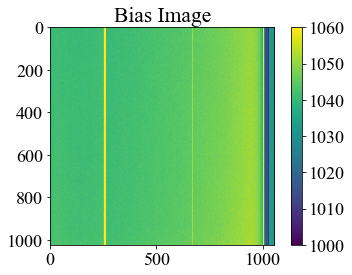

In [5]:
Z=plt.imshow(bias_median, vmin=1000, vmax=1060)
plt.colorbar(Z)
plt.title("Bias Image")

Text(0.5, 1.0, 'Dark Image')

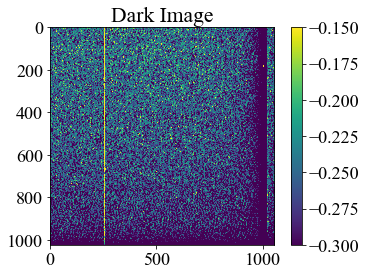

In [6]:
Z=plt.imshow(dark_median, vmin=-0.3, vmax=-0.15)
plt.colorbar(Z)

plt.title("Dark Image")

Text(0.5, 1.0, 'Dome Flat B')

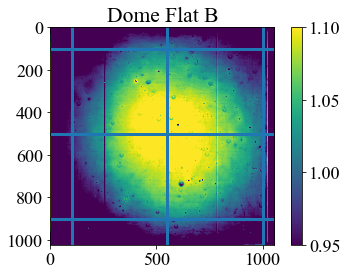

In [7]:
Z=plt.imshow(flats_medianB, vmin=0.95, vmax=1.1)
plt.colorbar(Z)
plt.axvline(550, lw=3)
plt.axhline(500, lw=3)

plt.axvline(100, lw=3)
plt.axhline(100, lw=3)
plt.axhline(900, lw=3)
plt.axvline(1000, lw=3)
plt.title("Dome Flat B")

In [8]:
#subtracing the sky background from all fields
from astropy.stats import sigma_clipped_stats
from photutils import SExtractorBackground
from astropy.stats import SigmaClip

def remove_sky(image):
    #Landolt B
    bkg=SExtractorBackground(SigmaClip(sigma=3.0))
    bkg_value=bkg.calc_background(image)
    mean,median,std=sigma_clipped_stats(image,sigma=3.0)
    answer=image-median
    
    return answer

landoltB_2 = remove_sky(landoltB)
landoltV_2 = remove_sky(landoltV)
ngc6819B_2 = remove_sky(ngc6819B)
ngc6819V_2 = remove_sky(ngc6819V)

print(landoltB_2)

[[   19.6243631     51.9486821     13.54730519 ...  -645.38002528
    537.49002297  -724.70093864]
 [    8.34807975    22.8262558     13.05929029 ...   735.87914781
    337.96016864   279.27734695]
 [    9.18567085    14.81495687    15.10110536 ... -6090.12648137
   1752.8701084    920.46365246]
 ...
 [   51.19352226    76.48824772    61.00452194 ...   340.5858918
    331.41169858  4580.98931436]
 [   62.64929789    52.35650656    50.19994075 ...   661.47198331
    438.0744117    833.25943144]
 [   34.51902462    58.82389127    48.43542371 ...  2284.01962911
   3728.27927602   515.47202417]]


(0.0, 1010.0)

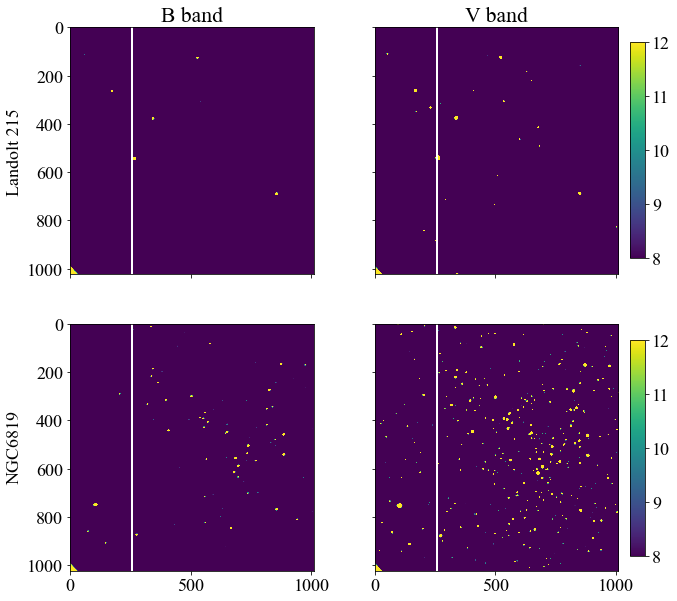

In [9]:
#plotting to see

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True, sharey=True)

ax = axs[0,0]
Z = ax.imshow(landoltB_2, vmin=8, vmax=12)
ax.set_ylabel("Landolt 215")
ax.set_title("B band")
ax.set_xlim(0, 1010)

ax = axs[0,1]
Z = ax.imshow(landoltV_2, vmin=8, vmax=12)
ax.set_title("V band")
cb_ax = fig.add_axes([.91,.56,.02,.3])
fig.colorbar(Z,orientation='vertical',cax=cb_ax)
ax.set_xlim(0, 1010)

ax = axs[1,0]
Z = ax.imshow(ngc6819B_2, vmin=8, vmax=15)
ax.set_ylabel("NGC6819")
ax.set_xlim(0, 1010)

ax = axs[1,1]
Z = ax.imshow(ngc6819V_2, vmin=8, vmax=12)
cb_ax = fig.add_axes([.91,.145,.02,.3])
fig.colorbar(Z,orientation='vertical',cax=cb_ax)
ax.set_xlim(0, 1010)

In [10]:
hdu = fits.PrimaryHDU(landoltB_2)
hdu.writeto('LandoltB.fits', overwrite=True) #saving to look at in DS9

In [11]:
from photutils import DAOStarFinder
from photutils import CircularAperture

(0.006167272135140933, -0.005153950381394878, 0.36930960809560465)


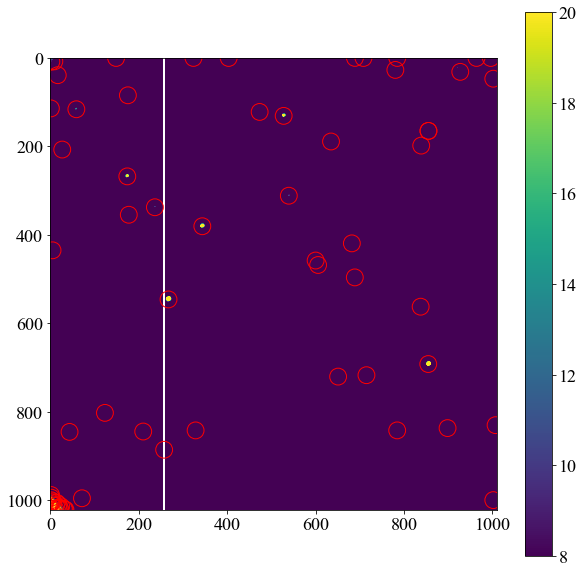

In [12]:
#testing out the source finding package from photutils. Also getting the x and y positions of the landolt stars

x1965 = 346 
y1965 = 381
x1969 = 268
y1969 = 548
x1925 = 855
y1925 = 693

xc1965, yc1965 = photutils.centroids.centroid_sources(landoltB_2, x1965, y1965)
xc1969, yc1969 = photutils.centroids.centroid_sources(landoltB_2, x1969, y1969)
xc1925, yc1925 = photutils.centroids.centroid_sources(landoltB_2, x1925, y1925)


from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(landoltB_2[:,:1010], sigma=3.0)  
print((mean, median, std))  

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(landoltB_2[:,:1010] - median) 

positions=np.transpose((sources['xcentroid'],sources['ycentroid']))
apertures=CircularAperture(positions,r=7./(0.184*2))

plt.figure(figsize=(10,10))
plt.imshow(landoltB_2[:, :1010],vmin=8,vmax=20)
apertures.plot(color='r',lw=1)
plt.colorbar()

In [13]:
#photometry on landolt
apertures = CircularAperture([(xc1965[0], yc1965[0]),(xc1969[0], yc1969[0]),(xc1925[0], yc1925[0])], r=7/(0.184*2))

from photutils import aperture_photometry

phot_table = aperture_photometry(landoltB_2, apertures)
print(phot_table)

 id      xcenter           ycenter         aperture_sum   
           pix               pix                          
--- ----------------- ----------------- ------------------
  1 344.2879527703545 380.6524376090237 4168.3678648076275
  2 267.4880103782738 546.5054648576103                nan
  3 854.9046945238783  692.518983636927  6217.917807299911


In [14]:
# 2.5*log

counts_1965 = 4168.3678648076275  #counts/sec
Bmag_1965 = 13.129  #from Landolt website
ZP_B1 = Bmag_1965 + 2.5*np.log10(counts_1965)


counts_1925 = 6217.917807299911 #counts/sec
Bmag_1925 = 12.783 #from Landolt website
ZP_B2 = Bmag_1925 + 2.5*np.log10(counts_1925)

In [15]:
print(ZP_B1)
print(ZP_B2)

ZP_B = (ZP_B1+ZP_B2)/2 #averaging the two
print(ZP_B)

22.178915097829332
22.267112442357337
22.223013770093335


In [16]:
hdu = fits.PrimaryHDU(landoltV_2)
hdu.writeto('LandoltV.fits', overwrite=True) #saving to look at in DS9

x1965 = 337 #guesses from DS9
y1965 = 377
x1969 = 260
y1969 = 544
x1925 = 848
y1925 = 689

xc1965, yc1965 = photutils.centroids.centroid_sources(landoltV_2, x1965, y1965) #actual centroids for photometry
xc1969, yc1969 = photutils.centroids.centroid_sources(landoltV_2, x1969, y1969)
xc1925, yc1925 = photutils.centroids.centroid_sources(landoltV_2, x1925, y1925)

In [17]:
#photometry on landolt stars
apertures = CircularAperture([(xc1965[0], yc1965[0]),(xc1969[0], yc1969[0]),(xc1925[0], yc1925[0])], r=7/(0.184*2))

from photutils import aperture_photometry

phot_table = aperture_photometry(landoltV_2, apertures)
print(phot_table)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 336.73003705368546 378.48724687574594 26886.583300484017
  2 260.40412978763965  544.2507160027559                nan
  3  847.8582317310767  690.4292311566027  11815.93702510953


In [18]:
counts_1965 = 26886.583300484017  #counts/sec
Vmag_1965 = 11.419  #from Landolt website
ZP_V1 = Vmag_1965 + 2.5*np.log10(counts_1965)


counts_1925 = 11815.93702510953 #counts/sec
Vmag_1925 = 12.388 #from Landolt website
ZP_V2 = Vmag_1925 + 2.5*np.log10(counts_1925)

ZP_V = (ZP_V1+ZP_V2)/2 #taking the average of the two

In [19]:
print(ZP_V)

22.53100473002937


# Alligning both fields to same frame

In [20]:
#saving here so I can guess the centroid of a star in both fields using DS9
hdu = fits.PrimaryHDU(ngc6819V_2)
hdu.writeto('ngcV.fits', overwrite=True)

hdu = fits.PrimaryHDU(ngc6819B_2)
hdu.writeto('ngcB.fits', overwrite=True)

In [21]:
#calculating the centroid of the same star for both fields and aligning them. 

xb_star, yb_star = photutils.centroids.centroid_sources(ngc6819B_2, 534, 533)  #guess values from DS9
print(xb_star, yb_star)

ngc6819B_3 = ngc6819B_2[532-477:532+477, 534-477:534+477] #aligning to values

xv_star, yv_star = photutils.centroids.centroid_sources(ngc6819V_2, 531, 538)
print(xv_star, yv_star)


ngc6819V_3 = ngc6819V_2[537-477:537+477, 530-477:530+477]

[533.50145572] [532.48316036]
[529.72423157] [537.01003438]


In [22]:
#blink test on DS9 to see if aligning worked. It looks good to me.

hdu = fits.PrimaryHDU(ngc6819V_3)
hdu.writeto('ngcV_centered.fits', overwrite=True)

hdu = fits.PrimaryHDU(ngc6819B_3)
hdu.writeto('ngcB_centered.fits', overwrite=True)

# Getting B magnitudes from NGC6819

(-0.01982242747673252, -0.03144438639926772, 0.33514220616090895)


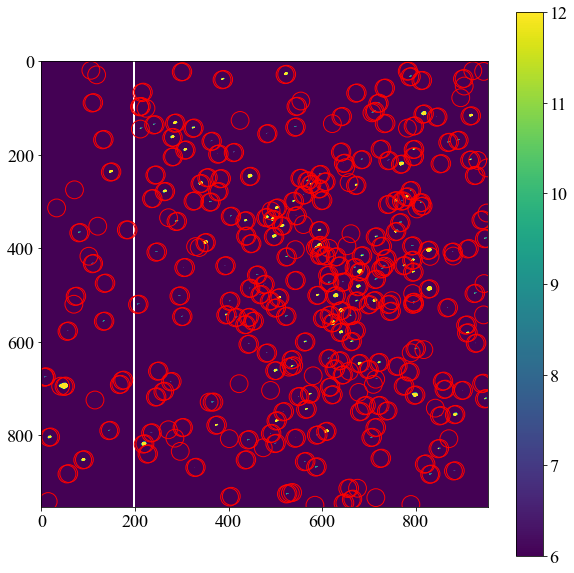

In [23]:
#locating sources and making the apertures using the Landolt values

mean, median, std = sigma_clipped_stats(ngc6819B_3, sigma=3.0)  
print((mean, median, std))  

daofind = DAOStarFinder(fwhm=2, threshold=7*std)  
sources = daofind(ngc6819B_3 - median) 

positions=np.transpose((sources['xcentroid'],sources['ycentroid']))
apertures=CircularAperture(positions,r=7./(0.184*2))

plt.figure(figsize=(10,10))
plt.imshow(ngc6819B_3,vmin=6,vmax=12)
apertures.plot(color='r',lw=1)
plt.colorbar()

In [24]:
print(positions.shape)

(559, 2)


In [25]:
from photutils import aperture_photometry
#photometry calc
apertures=CircularAperture(positions, r=7./(0.184*2))
phot_table_ngc_B = aperture_photometry(ngc6819B_3, apertures)


print(phot_table_ngc_B)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 105.65875358579163 19.824173053209154 360.56220983539214
  2  784.6037731350416 21.147426510588065  781.8317224613298
  3  921.8911268741166 20.704279468296345 284.37802169879535
  4  781.7176852846596 21.979112846259873  773.8401494558727
  5  945.0288122390027  22.12464620727518 264.09165565296087
  6  302.0190011163293 22.665675018405977 150.51383762188067
  7  298.7540315867626 23.477417568965198 141.53101159350632
  8  524.1170306926258 28.251517384621543  1265.136452547284
  9 117.99230310042708 29.542200441664484 478.44879662839026
 10  520.6665098123447 29.158830051429522 1261.1751868815559
...                ...                ...                ...
550  405.7195118865572  930.1341450400174 171.00332927010297
551  402.0227440850601  931.6602243058823 183.70493401290582
552  714.6469951008263  

<ipython-input-26-ba8f7b29123e>:2: RuntimeWarning: invalid value encountered in log10
  Bmag = -2.5*np.log10(phot_table_ngc_B["aperture_sum"]) + ZP_B


Text(0, 0.5, 'frequency')

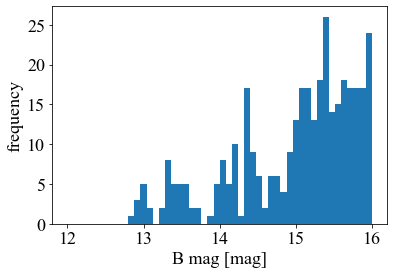

In [26]:
#Calculating B mag using the respective Zero Point and seeing the distribution
Bmag = -2.5*np.log10(phot_table_ngc_B["aperture_sum"]) + ZP_B

T = plt.hist(Bmag, bins=50, range=(12,16))
plt.xlabel("B mag [mag]")
plt.ylabel("frequency")

# Getting V magnitudes for NGC6819

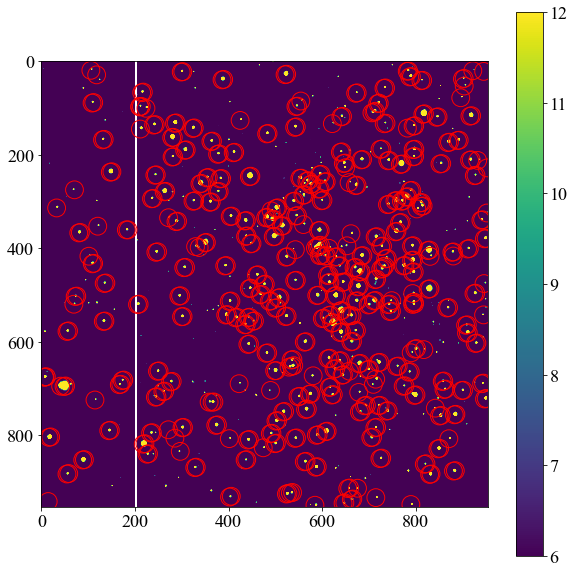

In [27]:
#Using same apertures as before on the V band image
plt.figure(figsize=(10,10))
plt.imshow(ngc6819V_3,vmin=6,vmax=12)
apertures.plot(color='r',lw=1)
plt.colorbar()

In [28]:
#photomety
from photutils import aperture_photometry

apertures=CircularAperture(positions, r=7./(0.184*2))
phot_table_ngc_V = aperture_photometry(ngc6819V_3, apertures)


print(phot_table_ngc_V)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 105.65875358579163 19.824173053209154 311.18417894816605
  2  784.6037731350416 21.147426510588065 1890.1401110765885
  3  921.8911268741166 20.704279468296345  342.6712011095558
  4  781.7176852846596 21.979112846259873 1887.0494752408788
  5  945.0288122390027  22.12464620727518  95.29439830359077
  6  302.0190011163293 22.665675018405977  542.7554173360631
  7  298.7540315867626 23.477417568965198  528.8873349654654
  8  524.1170306926258 28.251517384621543  6100.393213962286
  9 117.99230310042708 29.542200441664484  679.8800131110124
 10  520.6665098123447 29.158830051429522  6082.588994337428
...                ...                ...                ...
550  405.7195118865572  930.1341450400174   494.114881527419
551  402.0227440850601  931.6602243058823  496.1026169212911
552  714.6469951008263  

<ipython-input-29-54fa3b666771>:2: RuntimeWarning: invalid value encountered in log10
  Vmag = -2.5*np.log10(phot_table_ngc_V["aperture_sum"]) + ZP_V


Text(0, 0.5, 'frequency')

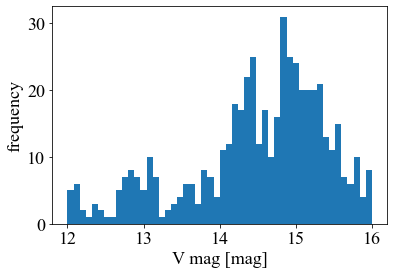

In [29]:
#calulating vmag based on zero point number and seeing the distribution. 
Vmag = -2.5*np.log10(phot_table_ngc_V["aperture_sum"]) + ZP_V

T = plt.hist(Vmag, bins=50, range=(12,16))
plt.xlabel("V mag [mag]")
plt.ylabel("frequency")

Text(0, 0.5, 'V [mag]')

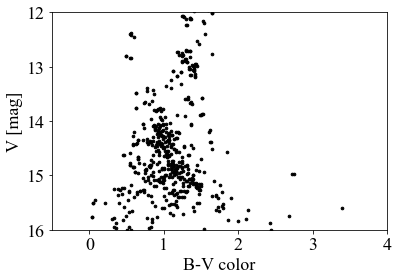

In [30]:
plt.scatter(Bmag-Vmag, Vmag, s=7, c='k')
plt.ylim(16,12)
plt.xlim(-0.5,4)
plt.xlabel('B-V color')
plt.ylabel("V [mag]")

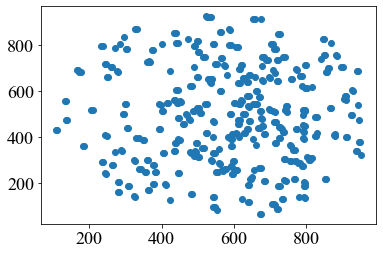

In [31]:
#selecting the area where the dome flat looks better. Just defined a circle using the box that I made in cell 7

xdata = np.asarray(phot_table_ngc_V["xcenter"])
ydata = np.asarray(phot_table_ngc_V["ycenter"])


circle_data = np.sqrt((xdata-550)**2 + (ydata-500)**2)

ichoose = np.where((circle_data <= 450))[0]

phot_table_new = phot_table_ngc_V[ichoose]

plt.scatter(phot_table_new["xcenter"], phot_table_new["ycenter"])


Text(0, 0.5, 'V [mag]')

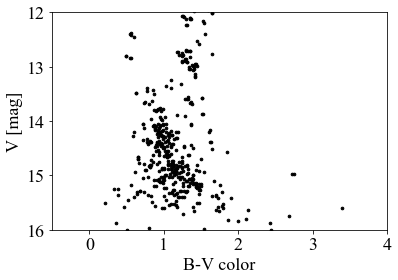

In [32]:
#Final plot. Still doesnt look great but the MS is more visible now.
plt.scatter(Bmag[ichoose]-Vmag[ichoose], Vmag[ichoose], s=7, c='k')
plt.ylim(16,12)
plt.xlim(-0.5,4)
plt.xlabel('B-V color')
plt.ylabel("V [mag]")